In [2]:
import os
import pandas as pd
import numpy as np


Cell — Mean Absolute Value Extraction (8 Sensors)

This cell reads every vibration file in the 1st Test folder.
Each file contains 8 sensor channels with 20,480 samples recorded in 1 second.

For each file:

The mean absolute value (MAV) is computed for all 8 sensors

A single-row summary is created

The filename is converted into a real timestamp

All rows are merged and sorted by time

This produces a clean time-series dataset showing vibration intensity trends across all sensors.

In [ ]:

data_dir = r'\Dataset\1st_test'
data_frames = [] 

for filename in os.listdir(data_dir):

    file_path = os.path.join(data_dir, filename)
    if not os.path.isfile(file_path):
        continue

    df = pd.read_csv(file_path, sep='\t', header=None)
    mean_abs_values = df.abs().mean().values      
    mean_df = pd.DataFrame(mean_abs_values.reshape(1, 8))
    mean_df.index = [filename]
    data_frames.append(mean_df)

merged_data = pd.concat(data_frames)

merged_data.columns = [
    'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4',
    'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 8'
]

merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')

merged_data = merged_data.sort_index()

merged_data.to_csv('merged_dataset_8_sensors.csv')

merged_data.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8
2003-10-22 12:06:24,0.104144,0.100250,0.107151,0.102002,0.106148,0.108152,0.094804,0.099515
2003-10-22 12:09:13,0.103652,0.099853,0.108190,0.102922,0.106660,0.108453,0.095070,0.093585
2003-10-22 12:14:13,0.105036,0.101540,0.108548,0.104041,0.108741,0.109881,0.096157,0.098300
2003-10-22 12:19:13,0.104898,0.101570,0.108150,0.103379,0.108073,0.110006,0.096813,0.098600
2003-10-22 12:24:13,0.104776,0.102188,0.107943,0.102626,0.108453,0.109349,0.096359,0.098468


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("merged_dataset_8_sensors.csv", index_col=0, parse_dates=True)


Cell — Missing Value Handling (Interpolation & Filling)
This cell cleans the time-series by filling any missing values:


interpolate(method='time') smoothly fills small gaps based on the timestamp.


fillna(method='bfill') fills remaining missing values by copying the next valid value.


fillna(method='ffill') fills any remaining gaps by copying the previous value.


This ensures the dataset has no missing points, keeping the time-series continuous for later modeling.

In [ ]:

df_interpolated = df.interpolate(method='time')

df_interpolated = df_interpolated.fillna(method='bfill')

df_interpolated = df_interpolated.fillna(method='ffill')


C:\Users\ASUS\AppData\Local\Temp\ipykernel_208756\3246856246.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated = df_interpolated.fillna(method='bfill')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_208756\3246856246.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated = df_interpolated.fillna(method='ffill')


Cell — Sensor Trend & Correlation Visualization

This cell provides two visual analyses:

1. Sensor Trend Plot

Plots the raw Sensor 1 vibration signal over time.

Adds a rolling mean (window = 50) for Sensor 2 to smooth short-term fluctuations and highlight overall trends.

This helps identify gradual changes or abnormal spikes in vibration behavior.

2. Correlation Heatmap

Computes the correlation between all 8 sensors.

The heatmap shows how strongly each sensor is related to the others.

This helps identify sensor pairs that behave similarly or detect different types of vibration patterns.

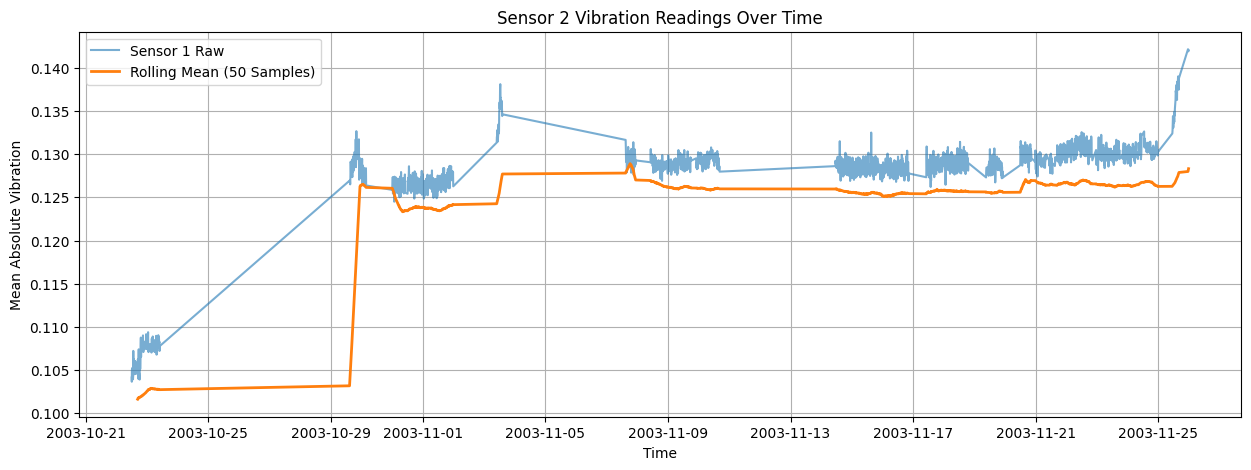

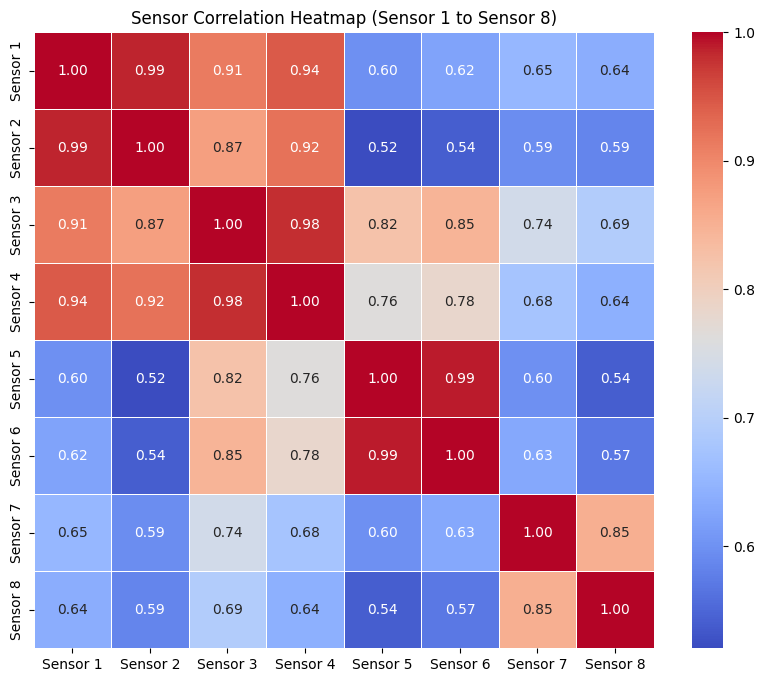

In [ ]:

plt.figure(figsize=(15, 5))
plt.plot(df_interpolated.index, df_interpolated['Sensor 1'], label='Sensor 1 Raw', alpha=0.6)

rolling_mean = df_interpolated['Sensor 2'].rolling(window=50).mean()
plt.plot(df_interpolated.index, rolling_mean, label='Rolling Mean (50 Samples)', linewidth=2)

plt.title("Sensor 2 Vibration Readings Over Time")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Vibration")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
corr_matrix = df_interpolated.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            linewidths=0.5, cbar=True)

plt.title("Sensor Correlation Heatmap (Sensor 1 to Sensor 8)")
plt.show()


Cell — Outlier Handling (Z-Score + Winsorization)

This cell cleans extreme spikes from the Sensor 1 signal:

Z-score is computed to identify abnormal points.

Values with |z| > 4 are treated as outliers and replaced with NaN.

Remaining extreme values are winsorized by clipping them between the 0.1% and 99.9% percentiles, preventing unrealistic spikes.

Missing values are then filled using linear interpolation, followed by backward/forward fill to keep the signal continuous.

A cleaned version of the signal (Sensor_1_clean) is added for smoother and more reliable analysis.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

sensor_z = zscore(df_interpolated['Sensor 1'], nan_policy='omit')

outlier_mask = np.abs(sensor_z) > 4

sensor_clean = df_interpolated['Sensor 1'].copy()
sensor_clean[outlier_mask] = np.nan

lower = sensor_clean.quantile(0.001)  
upper = sensor_clean.quantile(0.999)   

sensor_clean = sensor_clean.clip(lower=lower, upper=upper)

sensor_clean = sensor_clean.interpolate(method='linear')
sensor_clean = sensor_clean.fillna(method='bfill')
sensor_clean = sensor_clean.fillna(method='ffill')

df_interpolated['Sensor_1_clean'] = sensor_clean

df_interpolated[['Sensor 1', 'Sensor_1_clean']].head()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_208756\1744400807.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sensor_clean = sensor_clean.fillna(method='bfill')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_208756\1744400807.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sensor_clean = sensor_clean.fillna(method='ffill')


,Sensor 1,Sensor_1_clean
2003-10-22 12:06:24,0.104144,0.104144
2003-10-22 12:09:13,0.103652,0.103934
2003-10-22 12:14:13,0.105036,0.105036
2003-10-22 12:19:13,0.104898,0.104898
2003-10-22 12:24:13,0.104776,0.104776


Cell — Multi-Sensor Feature Engineering

This cell extracts meaningful rolling features from all 8 sensors to capture both vibration intensity and short-term fluctuations:

RMS (Root Mean Square): Measures vibration power and highlights increasing wear.

Rolling Standard Deviation: Detects short-term variability or instability in the signal.

Rolling Kurtosis: Identifies sharp peaks or transient impacts that often indicate bearing faults.

A rolling window (100 or 500 samples) is used to compute these statistics across time.

After feature extraction:

Initial rows containing NaN (from rolling windows) are removed.

All features are standardized with StandardScaler to ensure equal weighting during modeling.

The resulting feature_df_scaled DataFrame is a clean, normalized feature set for the anomaly-detection models.

In [ ]:
from scipy.stats import kurtosis
from sklearn.preprocessing import StandardScaler

feature_df = pd.DataFrame(index=df_interpolated.index)

for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4',
               'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 8']:

    feature_df[f'{sensor}_rms'] = df_interpolated[sensor].rolling(window=100).apply(
        lambda x: np.sqrt(np.mean(x**2)), raw=True
    )

    feature_df[f'{sensor}_roll_std'] = df_interpolated[sensor].rolling(window=100).std()

    feature_df[f'{sensor}_roll_kurt'] = df_interpolated[sensor].rolling(window=500).apply(
        kurtosis, raw=True
    )

feature_df = feature_df.dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

feature_df_scaled = pd.DataFrame(
    scaled_features,
    index=feature_df.index,
    columns=feature_df.columns
)

feature_df_scaled.head()


,Sensor 1_rms,Sensor 1_roll_std,Sensor 1_roll_kurt,Sensor 2_rms,Sensor 2_roll_std,Sensor 2_roll_kurt,Sensor 3_rms,Sensor 3_roll_std,Sensor 3_roll_kurt,Sensor 4_rms,...,Sensor 5_roll_kurt,Sensor 6_rms,Sensor 6_roll_std,Sensor 6_roll_kurt,Sensor 7_rms,Sensor 7_roll_std,Sensor 7_roll_kurt,Sensor 8_rms,Sensor 8_roll_std,Sensor 8_roll_kurt
2003-11-01 21:51:44,-3.089922,-0.091675,-0.971861,-3.895325,-0.228023,-1.074580,-0.320651,-0.134112,-0.519095,0.358749,...,-0.317993,-0.423078,-0.168756,-0.380916,-0.537304,-0.645412,-0.789703,-0.602651,-0.652495,-0.650589
2003-11-01 22:01:44,-3.081357,-0.077892,-0.967595,-3.911113,-0.229743,-1.069317,-0.327540,-0.135716,-0.516730,0.332361,...,-0.316162,-0.421206,-0.168455,-0.378663,-0.539805,-0.629015,-0.788232,-0.599671,-0.650965,-0.649557
2003-11-01 22:11:44,-3.063213,-0.045369,-0.963481,-3.887794,-0.204664,-1.064135,-0.319694,-0.133713,-0.514288,0.340099,...,-0.314256,-0.416011,-0.165375,-0.376349,-0.539302,-0.629515,-0.787015,-0.598585,-0.648861,-0.646518
2003-11-01 22:21:44,-3.066254,-0.048709,-0.958808,-3.891401,-0.208970,-1.058420,-0.334141,-0.153796,-0.511809,0.332057,...,-0.312260,-0.420425,-0.169532,-0.373930,-0.541399,-0.628577,-0.785852,-0.602618,-0.644643,-0.644195
2003-11-01 22:31:44,-3.059754,-0.049164,-0.954084,-3.891191,-0.209226,-1.052597,-0.339680,-0.151043,-0.509276,0.327316,...,-0.310225,-0.419802,-0.169923,-0.371468,-0.542853,-0.624390,-0.784744,-0.602864,-0.644796,-0.642431


Cell — Isolation Forest Hyperparameter Tuning

This cell performs an unsupervised grid search to find the best Isolation Forest settings for anomaly detection:

Tests different n_estimators (200, 300, 400) and contamination levels (1%, 2%, 5%).

For each model, the variance of anomaly scores is calculated using score_samples().

Higher score variance means better separation between normal and abnormal points.

The parameter combination with the highest variance is selected as the best model.

This tuning method works without labels and helps choose a more sensitive and robust anomaly detector for high-dimensional vibration data.

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

param_grid = {
    "n_estimators": [200, 300, 400],
    "contamination": [0.01, 0.02, 0.05]
}

best_params = None
best_variance = -np.inf

results = []

for n_est in param_grid["n_estimators"]:
    for cont in param_grid["contamination"]:
        model = IsolationForest(
            n_estimators=n_est,
            contamination=cont,
            random_state=42
        )

        model.fit(feature_df_scaled)

        scores = model.score_samples(feature_df_scaled)

        var_score = np.var(scores)

        results.append({
            "n_estimators": n_est,
            "contamination": cont,
            "variance": var_score
        })

        if var_score > best_variance:
            best_variance = var_score
            best_params = (n_est, cont)

results_df = pd.DataFrame(results)

print("Best Parameters Found:")
print(f"n_estimators  = {best_params[0]}")
print(f"contamination = {best_params[1]}")
print(f"Best Variance = {best_variance:.6f}")

results_df


Best Parameters Found:
n_estimators  = 400
contamination = 0.01
Best Variance = 0.003031


,n_estimators,contamination,variance
0,200,0.01,0.002981
1,200,0.02,0.002981
2,200,0.05,0.002981
3,300,0.01,0.003016
4,300,0.02,0.003016
5,300,0.05,0.003016
6,400,0.01,0.003031
7,400,0.02,0.003031
8,400,0.05,0.003031


 Cell — Isolation Forest: Anomaly Detection (Approach 1)
This cell applies the Isolation Forest model to identify unusual vibration patterns in the sensor data:


The model is trained using the best-tuned parameters (n_estimators=400, contamination=0.01).


fit_predict() assigns each time point as normal (1) or anomalous (-1).


Anomaly scores from score_samples() measure how abnormal each point is.


These results are added back to the dataset using proper index alignment.


A time-series plot overlays the raw Sensor 1 signal with red markers showing where anomalies were detected.
This visual inspection helps understand when the machine exhibits abnormal vibration behavior.

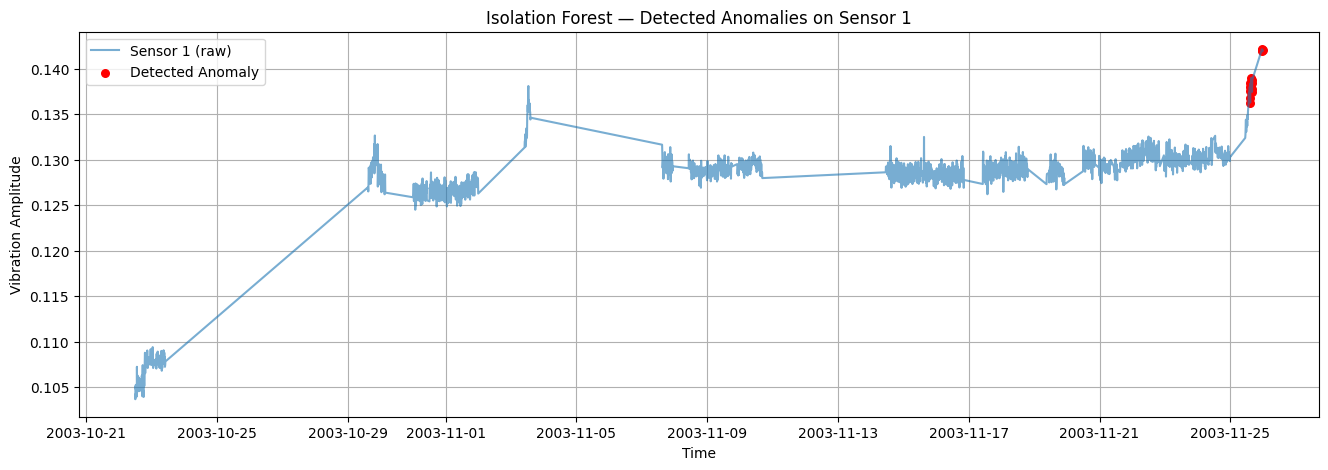

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

iso_model = IsolationForest(
    n_estimators=400,        
    contamination=0.01,      
    random_state=42
)

iso_model.fit(feature_df_scaled)

iso_labels = iso_model.fit_predict(feature_df_scaled)

iso_scores = iso_model.score_samples(feature_df_scaled)

df_interpolated['anomaly_iso'] = np.nan
df_interpolated['iso_score'] = np.nan

df_interpolated.loc[feature_df_scaled.index, 'anomaly_iso'] = iso_labels
df_interpolated.loc[feature_df_scaled.index, 'iso_score'] = iso_scores


plt.figure(figsize=(16, 5))
plt.plot(df_interpolated.index, df_interpolated['Sensor 1'], 
         label='Sensor 1 (raw)', alpha=0.6)

anomalies = df_interpolated[df_interpolated['anomaly_iso'] == -1]

plt.scatter(
    anomalies.index,
    anomalies['Sensor 1'],
    color='red',
    s=30,
    label='Detected Anomaly'
)

plt.title("Isolation Forest — Detected Anomalies on Sensor 1")
plt.xlabel("Time")
plt.ylabel("Vibration Amplitude")
plt.legend()
plt.grid(True)
plt.show()



 Cell — Sequence Preparation for LSTM Autoencoder
This cell prepares the Sensor 1 time-series data for the LSTM Autoencoder:


Missing values are replaced with zero to keep the sequence continuous.


The signal is scaled using StandardScaler for stable LSTM training.


A helper function splits the data into overlapping sequences of 30 time steps.


These sequences form the 3D input required by LSTM models:
(samples, time_steps, features)


Finally, the dataset is split into 80% training and 20% testing.


This step converts raw sensor readings into a sequential format that the LSTM Autoencoder can learn and reconstruct.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def create_sequences(data, time_steps=30):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data[i : (i + time_steps)]
        sequences.append(seq)
    return np.array(sequences)

if "Sensor_1_clean" in df_interpolated.columns:
    sensor_data = df_interpolated["Sensor_1_clean"].values
else:
    sensor_data = df_interpolated["Sensor 1"].values

sensor_data = np.nan_to_num(sensor_data, nan=0.0)

scaler = StandardScaler()
sensor_scaled = scaler.fit_transform(sensor_data.reshape(-1, 1))

TIME_STEPS = 30   

X_seq = create_sequences(sensor_scaled, time_steps=TIME_STEPS)

print("Sequence Shape:", X_seq.shape)

train_size = int(0.8 * len(X_seq))

X_train = X_seq[:train_size]
X_test  = X_seq[train_size:]

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)


Sequence Shape: (2126, 30, 1)
Train Shape: (1700, 30, 1)
Test Shape: (426, 30, 1)


Cell — LSTM Autoencoder Model Training (Approach 2)

This cell builds and trains an LSTM Autoencoder to learn normal vibration patterns from Sensor 1 sequences:

The encoder LSTM compresses each 30-step sequence into a latent representation.

RepeatVector expands the latent vector back to sequence length.

The decoder LSTMs reconstruct the original sequence.

The model is trained using MSE loss and Adam optimizer.

EarlyStopping prevents overfitting by monitoring validation loss.

After 15 epochs of training, the model learns how normal sensor behavior looks and becomes ready for anomaly detection using reconstruction error.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

time_steps  = X_train.shape[1]   # = 30
n_features  = X_train.shape[2]   # = 1

model = Sequential([
    
    LSTM(64, activation='relu', return_sequences=False, input_shape=(time_steps, n_features)),

    RepeatVector(time_steps),

    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, X_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


print("Training complete!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                         
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
48/48 [==============================] - 

Cell — LSTM Autoencoder Evaluation & Anomaly Detection
This cell evaluates the trained LSTM Autoencoder by measuring how well it reconstructs the test sequences:


The model predicts reconstructed sequences for X_test.


The Mean Squared Error (MSE) between the original and reconstructed sequences is computed.


An anomaly threshold is set using the 3σ rule (mean + 3×std).


Any sequence with MSE above this threshold is flagged as an anomaly.


Two visualizations are produced:


Histogram of reconstruction errors with the threshold marked in red.


Time-series plot showing the Sensor 1 signal, with red dots marking anomaly points.


This step demonstrates how the LSTM Autoencoder detects unusual time periods based on high reconstruction error.

14/14 [==============================] - 0s 7ms/step
Anomaly Threshold (3σ): 0.08734970949719276
Total anomalies detected: 13


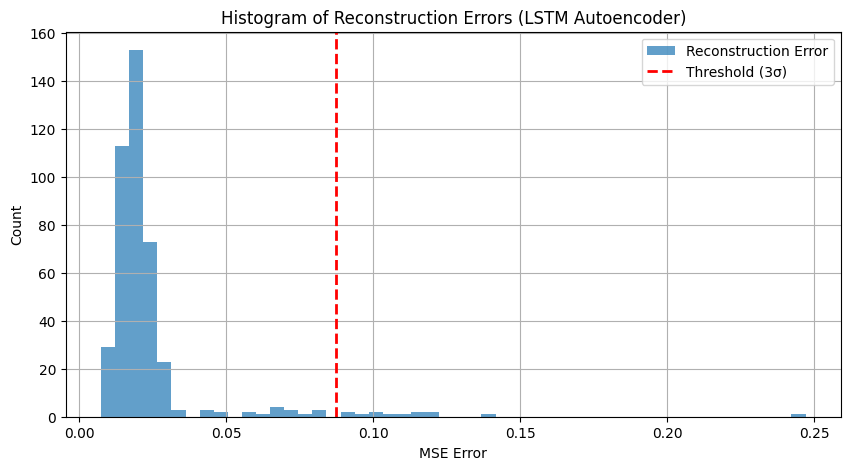

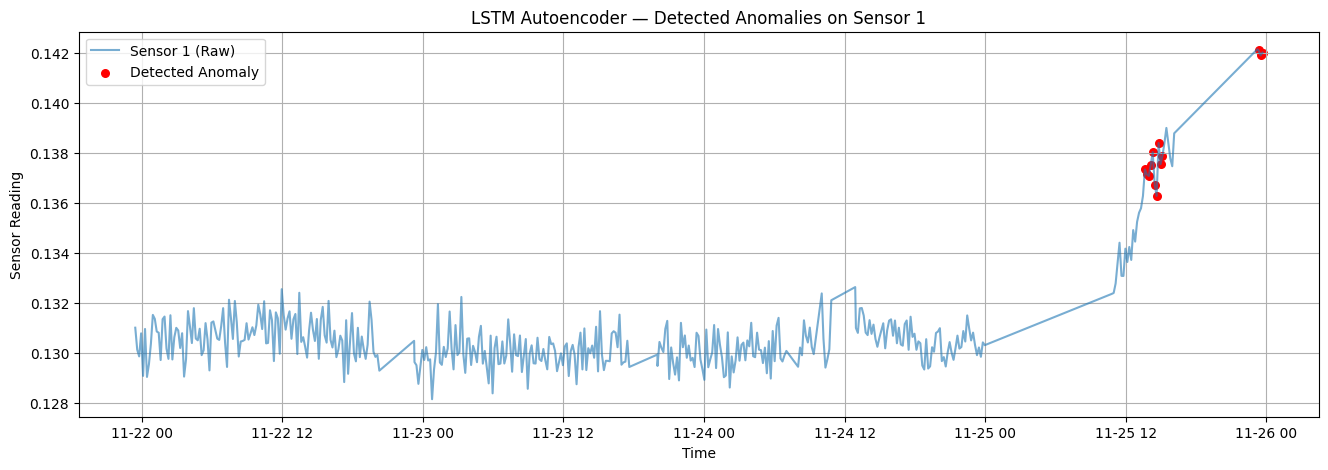

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_test_pred = model.predict(X_test)

mse = np.mean(np.power(X_test_pred - X_test, 2), axis=(1, 2))

threshold = np.mean(mse) + 3 * np.std(mse)
print("Anomaly Threshold (3σ):", threshold)

anomaly_flags = mse > threshold

print("Total anomalies detected:", np.sum(anomaly_flags))

plt.figure(figsize=(10, 5))
plt.hist(mse, bins=50, alpha=0.7, label="Reconstruction Error")
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label="Threshold (3σ)")
plt.title("Histogram of Reconstruction Errors (LSTM Autoencoder)")
plt.xlabel("MSE Error")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

test_index = df_interpolated.index[ len(df_interpolated) - len(X_seq) + len(X_train) : ]

test_index = test_index[:len(mse)]

sensor_test_values = df_interpolated["Sensor 1"].values[-len(test_index):]

plt.figure(figsize=(16, 5))
plt.plot(test_index, sensor_test_values, label="Sensor 1 (Raw)", alpha=0.6)

plt.scatter(
    test_index[anomaly_flags],
    sensor_test_values[anomaly_flags],
    color='red',
    s=30,
    label="Detected Anomaly"
)

plt.title("LSTM Autoencoder — Detected Anomalies on Sensor 1")
plt.xlabel("Time")
plt.ylabel("Sensor Reading")
plt.legend()
plt.grid(True)
plt.show()


Cell — Qualitative Comparison of Isolation Forest and LSTM Autoencoder

This cell visually compares the anomalies detected by the two unsupervised models:

The raw Sensor 1 signal is plotted as a blue line.

Isolation Forest anomalies (orange points) highlight sudden spikes or sharp deviations.

LSTM Autoencoder anomalies (red points) indicate longer-term pattern changes or reconstruction failures.

By overlaying both sets of anomalies on the same time-series plot, this visualization shows how each model behaves and helps identify strong anomaly regions where both models agree.

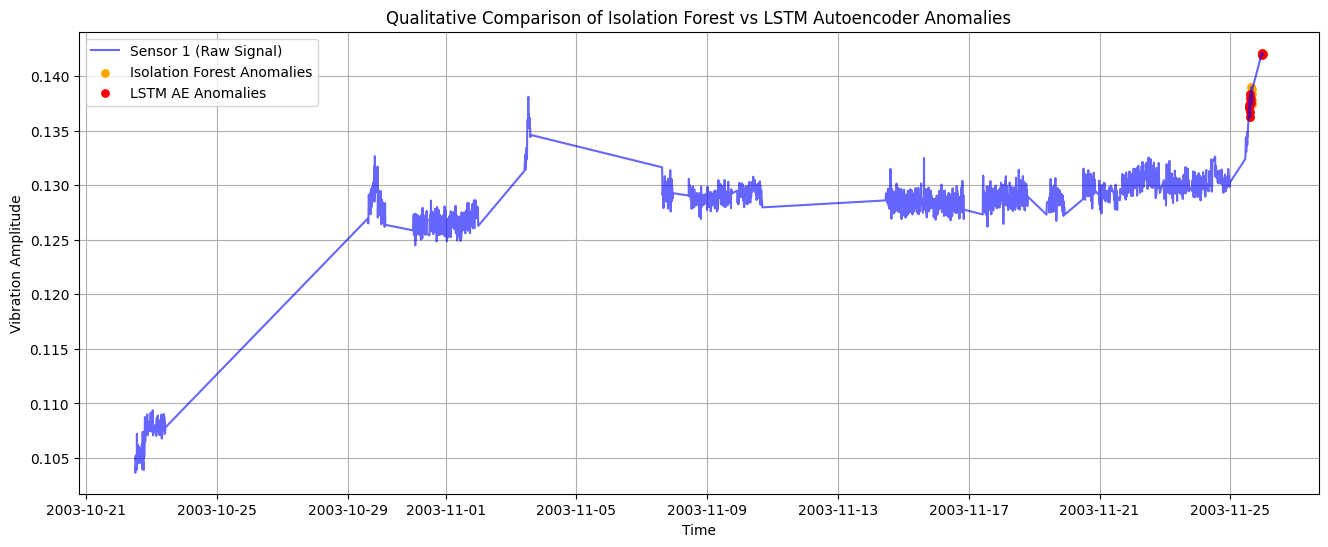

In [ ]:
import matplotlib.pyplot as plt
iso_anomalies = df_interpolated[df_interpolated['anomaly_iso'] == -1]
lstm_anomaly_times = test_index[anomaly_flags]
lstm_anomaly_values = sensor_test_values[anomaly_flags]

plt.figure(figsize=(16, 6))

plt.plot(df_interpolated.index, df_interpolated['Sensor 1'], 
         label="Sensor 1 (Raw Signal)", color="blue", alpha=0.6)

plt.scatter(
    iso_anomalies.index,
    iso_anomalies['Sensor 1'],
    color="orange",
    label="Isolation Forest Anomalies",
    s=28
)

plt.scatter(
    lstm_anomaly_times,
    lstm_anomaly_values,
    color="red",
    label="LSTM AE Anomalies",
    s=28
)

plt.title("Qualitative Comparison of Isolation Forest vs LSTM Autoencoder Anomalies")
plt.xlabel("Time")
plt.ylabel("Vibration Amplitude")
plt.grid(True)
plt.legend()
plt.show()


Cell — Unsupervised Model Evaluation (Visual Comparison)
This cell provides a side-by-side visual comparison of the anomalies detected by both unsupervised models:


The clean Sensor 1 signal is plotted as a blue baseline.


Isolation Forest anomalies (orange points) highlight sharp, sudden deviations in vibration.


LSTM Autoencoder anomalies (red points) mark longer-term sequence irregularities or reconstruction failures.


This overlay helps interpret how each method behaves and shows where both models agree, providing stronger evidence of abnormal machine behavior in the absence of ground-truth labels.

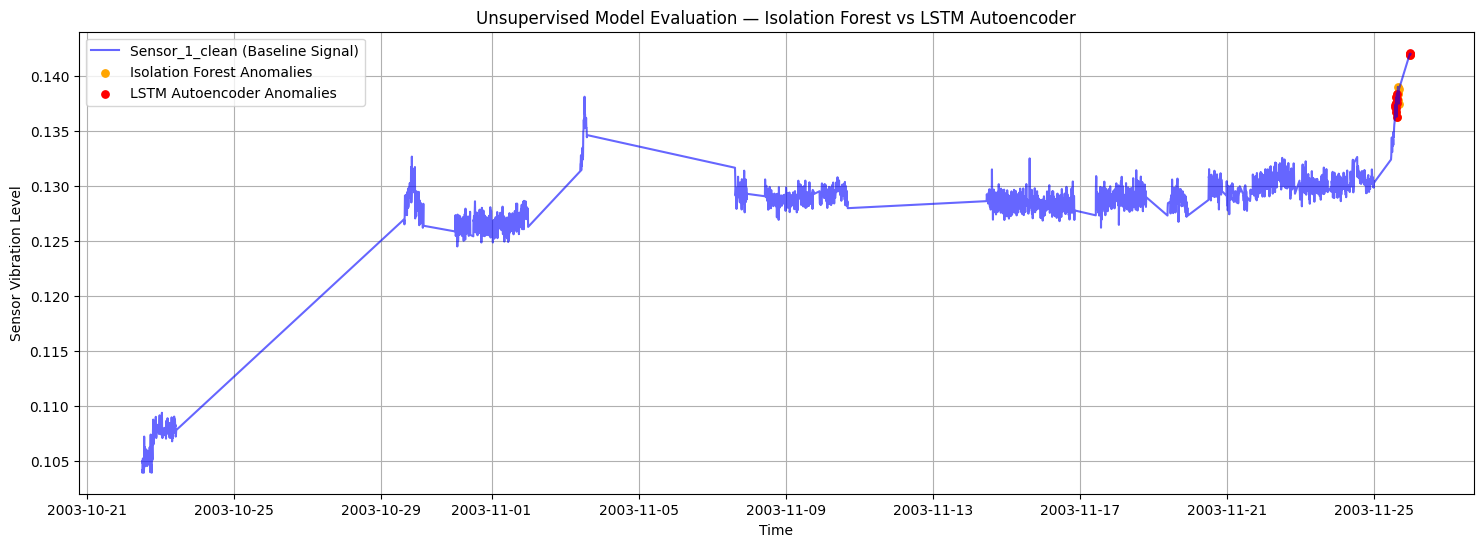

In [ ]:
import matplotlib.pyplot as plt

signal_col = "Sensor_1_clean" if "Sensor_1_clean" in df_interpolated.columns else "Sensor 1"

iso_anomalies = df_interpolated[df_interpolated["anomaly_iso"] == -1]

lstm_times = test_index[anomaly_flags]
lstm_values = sensor_test_values[anomaly_flags]


plt.figure(figsize=(18, 6))


plt.plot(
    df_interpolated.index, 
    df_interpolated[signal_col],
    color="blue",
    alpha=0.6,
    label="Sensor_1_clean (Baseline Signal)"
)


plt.scatter(
    iso_anomalies.index,
    iso_anomalies[signal_col],
    color="orange",
    s=28,
    label="Isolation Forest Anomalies"
)


plt.scatter(
    lstm_times,
    lstm_values,
    color="red",
    s=28,
    label="LSTM Autoencoder Anomalies"
)

plt.title("Unsupervised Model Evaluation — Isolation Forest vs LSTM Autoencoder")
plt.xlabel("Time")
plt.ylabel("Sensor Vibration Level")
plt.legend()
plt.grid(True)
plt.show()
